# Geoinformática - Práctica 6
## Agrupamiento, Regionalización y Segmentación Geodemográfica
## Parte 1 - Introducción a la Regionalización

In [1]:
# Librerías a Utilizar
import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


### Datos de Trabajo
En esta primera parte de la práctica, se utilizarán datos extraídos de la [Base de Datos oficial de AirBnb](http://insideairbnb.com/get-the-data.html); se trata de una compañía que provee alternativas de hospedaje diferentes de los hoteles a las personas que visitan un lugar determinado, así como de un ingreso adicional a aquellos con la posibilidad de rentar sus inmuebles. El [sitio web](https://www.airbnb.com/) de la compañía se actualiza de manera constante con el listado de todas las propiedades disponibles en un lugar dado para los usuarios puedan revisar y reservar según sus necesidades; asimismo, el servicio provee de un mecanismo de retroalimentación en el que ambas partes, tanto anfitriones como huéspedes, tienen la posibilidad de calificar su experiencia, lo cual permite que cada propiedad tenga no sólo una Calificación General de su aptitud como estancia, sino también puntuaciones relacionadas a la limpieza del inmueble, la facilidad de comunicación con el huésped, entre otras.

Los datos originales proporcionados por AirBnb se encuentran detallados a nivel propiedad para toda la Ciudad de México; sin embargo, dado que el número de inmuebles en esta base es demasiado alto, para propósitos de la práctica, los datos han sido agregados a nivel de AGEB. Asimismo, aunque los datos se encuentran disponibles para toda la ciudad, la gran mayoría de estas propiedades se encuentran concentradas en la Alcaldía Cuauhtémoc, donde se ubican los principales atractivos turísticos de la ciudad como el Centro Histórico, el Palacio de Bellas Artes o la Condesa; como tal, se trabajará únicamente con esta alcaldía y, dado que no todas las AGEB's de la alcaldía poseen un AirBnb, únicamente se trabajarán con las AGEB's de la Alcaldía Cuahtémoc que posean por lo menos un AirBnb en su interior, de modo que se le puedan asociar los promedios de calificaciones.

El objetivo de la práctica es crear una clasificación de las áreas (AGEB's) de la Alcaldía Cuauhtémoc, en la Ciudad de México, basándose en las calificaciones que los AirBnb en su interior han recibido. Esto permitirá crear una tipología para la geografía de AirBnb en la alcaldía y, hasta cierto punto, entender un poco mejor la distribución de las propiedades en la misma a través de lo que los propios AirBnb puedan decir del lugar en el que se encuentran. Por una parte, este ejercicio es una prueba idónea para demostrar el tipo de análisis que pueden realizarse gracias a la aparición de nuevas y grandes bases de datos en todas las áreas, algo que hace sólo algunos pocos años hubiera sido muy complicado de realizar por otros medios; por otra parte, es importante tomar en cuenta las restricciones que poseen este tipo de datos y, por ende, limitan la posibilidad de hacer interpretaciones completamente certeras hacia la población en general.

En primer lugar, y como se ha hecho hasta ahora, se establecerá una variable que contenga la ruta en la cual se encuentran almacenados los datos:

In [2]:
f = 'data/'

Después, puede importarse el `ShapeFile` a utilizar a lo largo de la práctica, como se ha hecho tradicionalmente a través de `geopandas`:

In [3]:
airbnb = gpd.read_file('data/agebs_airbnb.shp')  # Importar el ShapeFile
airbnb = airbnb.set_index('ageb')                # Establecer la Clave Geográfica del AGEB como Índice
airbnb.head()                                    # Observar el GeoDataFrame importado

,no_prop,calif,expec,limp,checkin,com,ubi,precio,geometry
ageb,,,,,,,,,
0901500010235,4.0,96.5000,10.00000,10.00000,10.00000,10.00000,10.00000,9.75000,"POLYGON ((484786.456 2151318.632, 484743.189 2..."
0901500010362,1.0,100.0000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484415.300 2150990.921, 484453.443 2..."
0901500010606,14.0,96.3571,9.92857,10.00000,10.00000,9.92857,9.71429,9.85714,"POLYGON ((483366.717 2150099.091, 483446.519 2..."
0901500011017,204.0,96.1569,9.83823,9.64706,9.86765,9.86765,9.92157,9.68627,"POLYGON ((483869.067 2147955.234, 483852.569 2..."
0901500010201,1.0,100.0000,9.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484252.797 2151134.264, 484264.757 2..."


A continuación se presenta el significado de cada una de las variables contenidas en el `GeoDataFrame`; es importante recordar que las calificaciones mostradas para cada AGEB resultan del promedio de todas las propiedades contenidas en su interior:
* `no_prop` - Número de Propiedades contenidas en el AGEB.
* `calif` - Calificación General de las Propiedades, en una escala del 0 al 100.
* `expec` - Calificación de Expectativa, es decir, qué tanto se asemeja la experiencia real con lo prometido.
* `limp` - Calificación de Limpieza general de la propiedad.
* `checkin` - Calificación de la facilidad con la que fue posible realizar el Check-In a la propiedad.
* `com` - Calificación de facilidad de Comunicación entre el huésped y el anfitrión
* `ubi` - Calificación de Ubicación de la propiedad con respecto a la accesibilidad a otros lugares de la ciudad.
* `precio` - Calificación del Precio, es decir, el equilibrio entre lo pagado y lo recibido.

Antes de comenzar a explorar los datos más a fondo, resulta de utilidad realizar un paso más. Puede observarse que no todas las variables contenidas en la tabla resultarán de utilidad para el ejercicio, sino únicamente las asociadas a las calificaciones; como tal, para facilitar el trabajo a futuro, se almacenará el nombre de cada una de estas dentro de una *Lista* (*Array*):

In [4]:
calificaciones = ['calif', 'expec', 'limp', 'checkin', 'com', 'ubi', 'precio']

___
### Conociendo los Datos
La mejor forma de comenzar a estudiar la geografía de las Calificaciones de AirBnb es graficandolas a todas ellas dentro de un mapa particular para cada una, lo cual nos dará una perspectiva univariada de cada una de las variables de interés.

Debido a que existen muchas columnas de las cuales generar un mapa, puede utilizarse un Bucle (*Loop*) del tipo `for` que genere cada uno de estos mapas, y los coloque dentro de una de las unidades de la figura principal:

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not eno

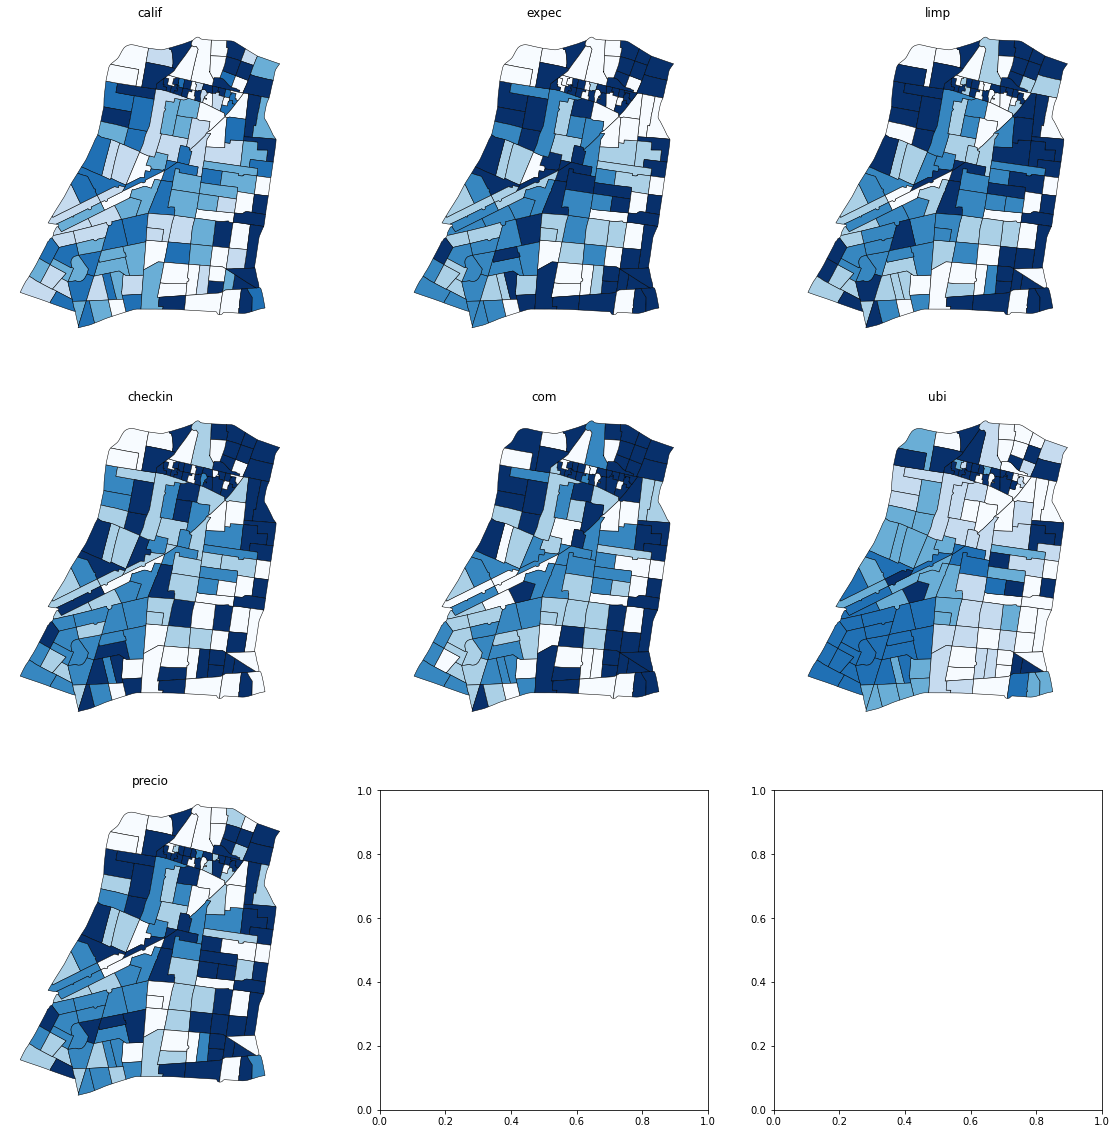

In [5]:
# Generación de figura con tres filas y tres columnas
fig, ejes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

# Hacer los accesibles a través de un solo índice con la función '.flatten()'
ejes = ejes.flatten()

# Comenzar el bucle utilizando todas las variables de interés
for i, var in enumerate(calificaciones):
    # Seleccionar el eje en el que se colocará el mapa
    eje = ejes[i]
    # Generar el mapa
    airbnb.plot(column=var, ax=eje, scheme='Quantiles', linewidth=0.5, edgecolor = 'black', cmap='Blues')
    # Remover los ejes del mapa
    eje.set_axis_off()
    # Colocar como título el nombre de la variable graficada
    eje.set_title(var)
    
plt.show()

Antes de realizar cualquier interpretación de los mapas, resulta pertinente estudiar a detalle el código que permitió generar los mapas anteriores:
1. Primero, en la Línea 2, se determina el número de filas y columnas de la cuadrícula en la cual se acomodarán los mapas, utilizando la función `.subplots()` de la librería `matplotlib`, así como sus argumentos `nrows` y `ncols` respectivamente.
2. Después, en la Línea 5, se utiliza la función `.flatten()` para que cada uno de los espacios de la cuadrícula puedan ser llamados de forma individual. Puede pensarse como una forma de enumerar los espacios de la cuadrícula; como tal, si se llama al elemento `ejes[0]` (recordando que *Python* comienza a enumerar desde 0), se estará trabajando con el primer cuadro de la primera fila; el elemento `ejes[1]` corresponderá al segundo de la primera fila; `ejes[2]` al tercero de la primera fila; `ejes[3]` al primero de la segunda fila, y así consecutivamente.
3. En la Línea 8 se genera el bucle de tipo `for` utilizando la lista de `calificaciones` que se generó anteriormente; sin embargo, se está aplicando el método `enumerate()` sobre la lista. Esto se debe a que la función `enumerate()`, como indica su nombre, enumera a los elementos de la lista; como tal, en la lista `calificaciones`, al elemento `calif` se le asigna el número 0, a `expec` el número 1, y así con el resto. Lo anterior permite que las variables generadas por el bucle, `var` e `i`, correspondan a la variable con la que se generará el mapa y su ennumeración correspondiente, respectivamente.
4. Dentro del bucle, primero se establece con cual de los ejes (o, elemento de la cuadrícula) se trabajará para generar el mapa (Línea 10); después, se genera el mapa a través de la función `.plot()` (Línea 12); posteriormente, se remueven los ejes del mapa generado con `.set_axis_off()` (Línea 14) y, por último, se le coloca como título al mapa el nombre de la variable con la que se ha trabajado.
5. Para finalizar, simplemente se muestra el resultado (Línea 18).

Gracias a los mapas generados, es posible observar que existe una diferencia sustancial en cómo se distribuyen las calificaciones de cada uno de los aspectos de un AirBnb en el espacio. Mientras que la Calificación General (`calif`), la de Comunicación con el Anfitrión (`com`) y la Ubicación (`ubi`) tienden a ser altas en muy pocas AGEB's, principalmente las concentradas en los límites de la alcaldía, otras calificaciones como las de Precio (`prec`) o Expectativa (`expec`) también tienden a concentrarse en el centro de la misma, donde se encuentra el Centro Histórico.

Aunque se está trabajando con un número relativamente pequeño de variables, resulta complicado a primera instancia determinar cómo funcionan en conjunto y de qué forma se relacionan como un todo con la naturaleza de cada una de las AGEB's estudiadas. Como tal, también resulta de utilidad estudiar la Correlación entre cada una de las variables (como influye una en la otra) y, para esto, la librería `seaborn` ofrece la función [`.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html), que permite estudiar esta correlación entre un grupo de variables de forma gráfica:

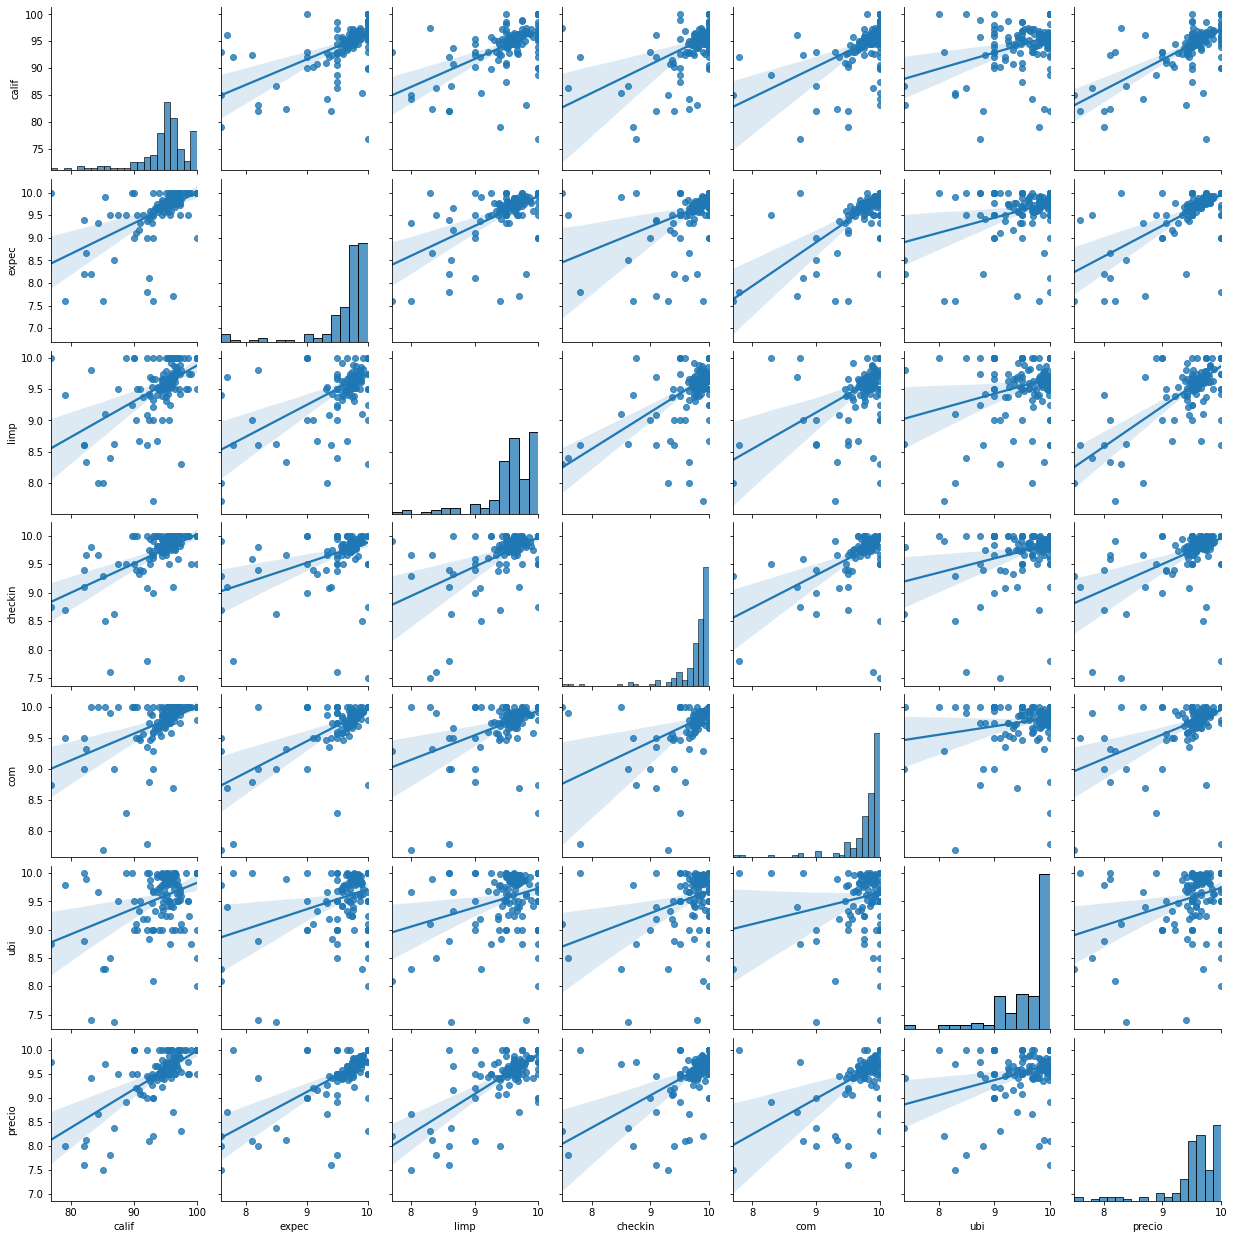

In [6]:
_ = sns.pairplot(airbnb[calificaciones], kind='reg', diag_kind='hist')

El conjunto de gráficas anterior permite responder preguntas de naturaleza univariada o bivariada, como por ejemplo:
* *¿Cuál es el rango de calificaciones para el parámetro de Limpieza, y cuál es la calificación más común?* - En este caso, en la intersección del parámetro `limp` de ambos ejes se encuentra un Histograma que muestra que todas las calificaciones de este parámetro se encuentran en un rango de entre 8 y 10, siendo las más comunes las que se encuentran en un rango de entre 9.6 y 9.8.
* *¿Cuál es la relación entre la Calificación General y la de Ubicación?* - Si se observa la intersección entre `calif` y `ubi`, se observará que es de tipo *Positiva*, es decir, mientras mejor sea una calificación, mayor será la otra.
* *¿La Calificación General guarda una mayor correlación con la de Ubicación o la de Limpieza?* - Debido a que la recta presente en en la intersección de `calif` con `limp` presenta una mayor inclinación que la existente en la intersección con `ubi`, se concluye que la calificación de Limpieza tiene una mayor correlación.

Como tal, puede observarse que una gran cantidad de preguntas pueden responderse estudiando la correlación entre pares de variables; sin embargo, esto no puede resultar suficiente cuando se hacen preguntas sofisticadas y de naturaleza multivariada. La figura anterior no permite responder con certeza preguntas como:
* ¿Cuáles son las principales características de la zona suroeste de la Alcaldía Cuauhtémoc?
* ¿Qué otras AGEB's son similares a las que contienen el Centro Histórico?
* ¿Los AirBnb encontrados al oriente de la alcaldía son similares a los presentes en el occidente?

Para responder este tipo de preguntas, que involucran una gran cantidad de variables al mismo tiempo, se requiere de un método verdaderamente multivariado, como lo es el *Agrupamiento Estadístico*.

#### Ejercicio Opcional
Revisa la [documentación oficial](https://seaborn.pydata.org/generated/seaborn.pairplot.html) de la función `.pairplot()` y experimenta con los parámetros de la misma; por ejemplo, cambia los Histogramas generados en la figura de arriba por Estimaciones de Densidad de Kernel (KDE).

## Solución 6.1

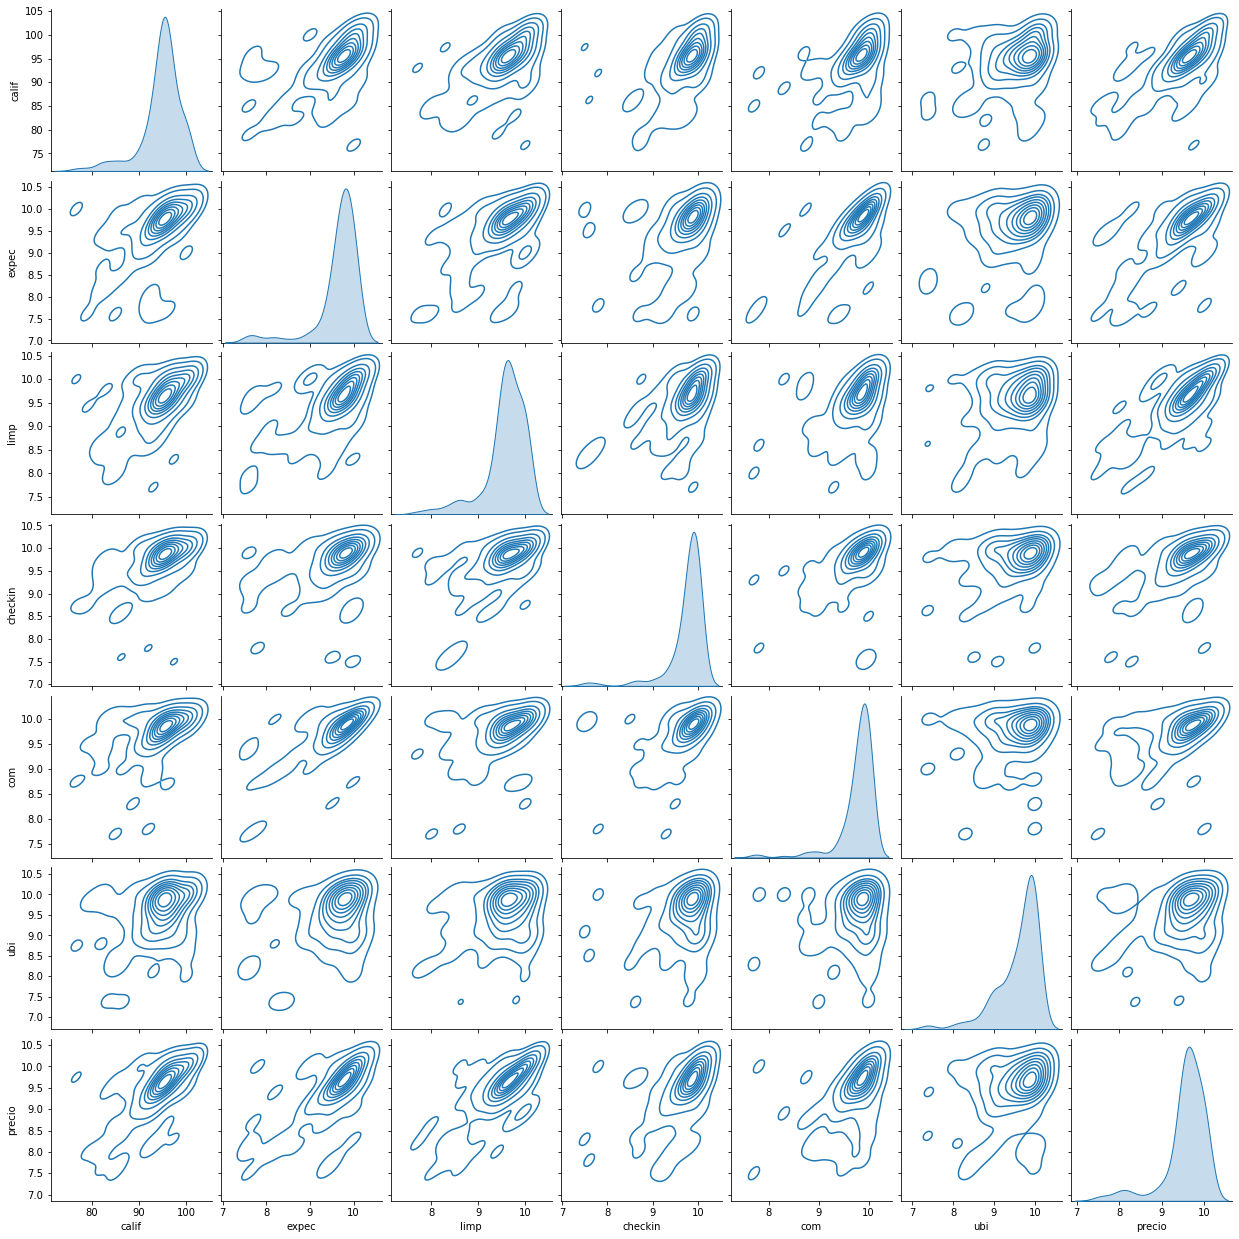

In [7]:
_=sns.pairplot(airbnb[calificaciones], kind='kde')


Podemos ver que cada variable no tiene un comportamiento normal, de hecho no parece tener distribución de variable conocida, al menos eso podemos decir de las colas de estas distribuciones.

Por otro lado ninguna de las distribuciones bivariadas son parecidas a alguna conocida, en principio porque estan compuestas por distribuciones que ya comentamos no son del tipo "conocidas".

Algo interesante es que puede ser que algunas de las variables pertenezcan a distribuciones que son la suma de dos distribuciones, en tal caso se trataria de descomponerlas para obtener nuevos kernel distribution de estas.

___
### Clasificación Geodemográfica - Método *K-Means*
Un análisis geodemográfico invloucra la clasificación de las áreas que forman un mapa geográfico en grupos o categorías de observaciones que se asemejan entre sí, pero resultan diferentes a las presentes en otras categorías. La clasificación se lleva a cabo utilizando un algoritmo de *Agrupamiento Estadístico* (*Clustering*) que toma como referencia un conjunto de atributos y regresa el grupo (o la *etiqueta*) a la que pertenece cada una de las observaciones; dependiendo del algoritmo particular utilizado, parámetros adicionales deben de ser establecidos por el usuario, los cuales pueden variar desde elementos básicos como el número de agrupaciones deseado, hasta detalles más avanzados como ancho de banda, radio, entre otroas.

Para la Clasificación Geodemográfica de la Alcaldía Cuahtémoc utilizando las calificaciones de AirBnb, se utilizará uno de los algoritmos de *Agrupamiento Estadístico* más populares: *K-Means* (o *K-Medias*, al traducirlo al español). Esta técnica ´unicamente requiere como entrada los atributos de las observaciones a tomar como referencia y el número de grupos en los que se desea clasificar a las observaciones; en este caso, se iniciará generando únicamente cinco categorías, para entender con facilidad el resultado obtenido.

Aunque el algoritmo asociado al Método *K-Means* no es para nada trivial, ejecutarlo en *Python* es bastante sencillo gracias a la librería `scikit-learn`, pues únicamente se necesitan dos líneas de código. Primero se necesita ejecutar el método `.KMeans()`, perteneciente al submódulo `cluster` de la librería `scikit-learn`, para establecer los parámetros del algoritmo; en este paso, aún no es necesario introducir las variables, sino únicamente determinar el número de *Clusters* en los cuales se desea agrupar a los datos:

In [8]:
kmeans5 = cluster.KMeans(n_clusters=5)

El resultado del método `.KMeans()` fue almacenado dentro de una variable llamada `kmeans5`; aunque únicamente se colocó de forma explícita el argumento `n_clusters` para determinar el número deseado de grupos, el método posee muchos otros que establece por defecto, y que pueden ser revisados si se analiza a la variable generada:

In [9]:
kmeans5

KMeans(n_clusters=5)

Para verdaderamente ejecutar el algoritmo, es necesario ejecutar el método `.fit()` sobre la variable antes creada, esta vez estableciendo cuáles son las variables que se utilizarán como referencia para generar los grupos:

In [10]:
# Ejecutar el algoritmo con las variables establecidas
k5cls = kmeans5.fit(airbnb[calificaciones].values)

El objeto contenido dentro de la variable `k5cls` contiene una gran cantidad de componentes que pueden ser utilizados para el análisis; por ahora, únicamente se utilizará el llamado `labels_`, que representa las diferentes categorías en las cuales han sido agrupados los datos; es importante recordar que Python comienza su numeración desde el cero, por lo que las etiquetas se encuentran marcadas del 0 al 4 para representar cinco grupos:

In [11]:
k5cls.labels_

array([0, 3, 0, 0, 3, 3, 3, 0, 3, 3, 2, 4, 3, 3, 0, 2, 0, 2, 0, 0, 2, 0,
       0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 3, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 2, 4, 2, 3, 2, 3, 3, 1, 0, 0, 3, 3, 0, 2, 2, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 3, 0, 0, 0, 3, 2, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 4, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       3, 1, 1, 0, 0, 0, 0, 0, 0, 4, 2, 4, 2, 3, 3, 3, 2, 4, 1, 1, 4])

Cada número representa una categoría diferente, lo que significa que si a dos observaciones se les ha asignado el mismo número, entonces pertenecerán al mismo grupo. Dado que el orden en que se encuentran estas etiquetas es exactamente el mismo que el orden de los atributos utilizados para su generación, es posible colocar éstas como una nueva columna en el `GeoDataFrame` original:

In [12]:
airbnb['k5cls'] = k5cls.labels_
airbnb.head()

,no_prop,calif,expec,limp,checkin,com,ubi,precio,geometry,k5cls
ageb,,,,,,,,,,
0901500010235,4.0,96.5000,10.00000,10.00000,10.00000,10.00000,10.00000,9.75000,"POLYGON ((484786.456 2151318.632, 484743.189 2...",0
0901500010362,1.0,100.0000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484415.300 2150990.921, 484453.443 2...",3
0901500010606,14.0,96.3571,9.92857,10.00000,10.00000,9.92857,9.71429,9.85714,"POLYGON ((483366.717 2150099.091, 483446.519 2...",0
0901500011017,204.0,96.1569,9.83823,9.64706,9.86765,9.86765,9.92157,9.68627,"POLYGON ((483869.067 2147955.234, 483852.569 2...",0
0901500010201,1.0,100.0000,9.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484252.797 2151134.264, 484264.757 2...",3


___
### Visualización en Mapa
Para entender con más detalle el resultado obtenido, resulta útil visualizar las categorías generadas en un mapa. Para esto, se generará un Mapa de Coropletas en el que cada categoría se asociará automáticamente a un color diferente, lo cual se logra gracias al argumento `categorical` de la función `.plot()`:

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\geopandas\plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


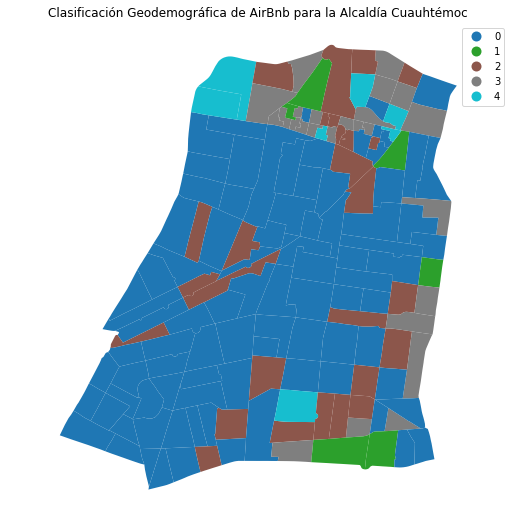

In [13]:

# Crear la figura y sus ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Generar un Mapa de Coropletas Categórico
airbnb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, axes=ax)
# Remover los ejes del mapa
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Asignar un título
plt.title('Clasificación Geodemográfica de AirBnb para la Alcaldía Cuauhtémoc')
# Mostrar el resultado
plt.show()

El mapa anterior representa la Distribución Geográfica de las cinco categorías creadas por el Algoritmo *K-Means*. A través de éste, es posible observar cierto patrón espacial en los resultados; por una parte, la Categorías 3 (Gris) es la que abarca la gran mayoría de la alcaldía, comprendiendo casi todas las AGEB's en el centro y suroeste de la misma; la Categoría 0 (Azul Oscuro) es la siguiente en términos de tamaño, distribuyéndose principalmente en los límites norte y este; las Categorías 1, 2 y 4 son las del menor número de elementos, distribuyéndose de forma algo heterogénea a lo largo de toda la alcaldía..
___
### Analizando las Categorías
Resulta útil no sólo entender cómo es que se han distribuído las categorías en el espacio, sino también entender el porqué los elementos se han agrupado de la forma en que lo hicieron, razón por la cual se recurre a la Estadística. Como primer paso, es importante saber cuántas observaciones fueron asignadas a cada categoría; para ello, se utilizará la función `.groupby()` de la librería `pandas`, [estudiada en prácticas anteriores](../01_transformacion/01_transformacion.html), utilizando también el método `.size()` que obtiene el número de elementos en un subgrupo:

In [14]:
k5_cuentas = airbnb.groupby('k5cls').size()
k5_cuentas

k5cls
0    88
1     6
2    27
3    25
4     7
dtype: int64

El operador `.groupby()` toma un `DataFrame` y lo agrupa utilizando los valores de una columna dada (`k5cls`), lo cual permite aplicar sobre éste alguna operación dada, en este caso `.size()`; en otras palabras, lo que se realiza es agrupar en función de las categorías creadas, y contar cuántos elementos posee cada una. Para entender esto visualmente, puede realizarse una Gráfica de Barras:

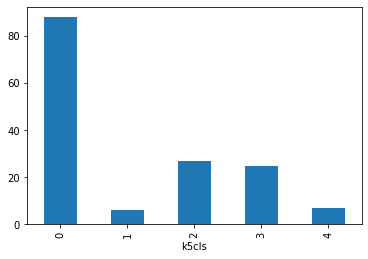

In [15]:
_ = k5_cuentas.plot.bar()

Como se observó en el mapa, cada una de las categorías posee un número diferente de elementos; la Categoría 3 rebasa por mucho las 80 observaciones, mientras que las Categorías 1 y 4 no logran superar las 20.

Para continuar describiendo las características de cada categoría, pueden estudiarse los valores de los atributos utilizados para crearlas. Recordando que se utilizaron las calificaciones de los AirBnb contenidos en cada AGEB para generar las categorías, podría estudiarse cuál terminó siendo el valor promedio de cada una de éstas dentro de las categorías; para esto, nuevamente se puede recurrir al método `.groupby()`, pero esta vez combinándolo con la función `.mean()`:

In [16]:
# Calcular la media de todas las calificaciones para cada Categoría
k5_promedios = airbnb.groupby('k5cls')[calificaciones].mean()

# Transponer la tabla, únicamente por cuestiones de visualización
k5_promedios.T

k5cls,0,1,2,3,4
calif,95.628698,80.880550,92.178007,99.640,86.273329
expec,9.763616,8.677778,9.303677,9.940,9.119047
limp,9.643755,9.122222,9.322186,9.920,8.803571
checkin,9.831191,9.236112,9.617744,9.960,8.955953
com,9.844971,9.347222,9.571053,9.992,9.271429
ubi,9.720142,9.106482,9.401412,9.660,8.805953
precio,9.657071,8.476852,9.321221,9.930,8.634524


Analizando únicamente la Calificación General (`calif`), podría decirse que las AGEB's con los AirBnb mejor claificados se concentran en la Categoría 0, mientras que los peor calificados son los de la Categoría 4.

Si se desea estudiar con mucho más detalle cada una de las categorías, desde el punto de vista estadístico, podría combinarse la función `.groupby()` con `.describe()`, lo cual arrojará un mayor número de cálculos:

In [17]:
# Obtener un Resumen Estadístico de cada una de las Categorías
k5_estad = airbnb.groupby('k5cls')[calificaciones].describe()
# Observar el resultado
k5_estad

calif                                                                \
      count       mean       std      min       25%       50%         75%   
k5cls                                                                       
0      88.0  95.628698  0.893971  93.8973   95.0000   95.5000   96.216800   
1       6.0  80.880550  2.473644  76.7500   79.7500   82.0000   82.249975   
2      27.0  92.178007  1.265489  89.7500   91.1652   92.5846   93.000000   
3      25.0  99.640000  0.673455  98.0000  100.0000  100.0000  100.000000   
4       7.0  86.273329  1.514944  84.3333   85.2000   86.2300   87.125000   

               expec            ...        ubi       precio            \
           max count      mean  ...        75%   max  count      mean   
k5cls                           ...                                     
0       97.400  88.0  9.763616  ...   9.955600  10.0   88.0  9.657071   
1       83.200   6.0  8.677778  ...   9.866668  10.0    6.0  8.476852   
2       93.875  27.0  9.303677  ...   9.743990  10.0   27.0  9.321221   
3      100.000  25.0  9.940000  ...  10.000000  10.0   25.0  9.930000   
4       88.700   7.0  9.119047  ...   9.583335  10.0    7.0  8.634524   

                                                             
            std  min       25%        50%        75%    max  
k5cls                                                        
0      0.247650  8.3   9.57143   9.639410   9.768532  10.00  
1      0.875274  7.6   8.00000   8.055555   9.077777   9.75  
2      0.440658  8.1   9.11905   9.416670   9.500000  10.00  
3      0.169558  9.5  10.00000  10.000000  10.000000  10.00  
4      0.817183  7.5   8.08750   8.666670   9.200000   9.70  

[5 rows x 56 columns]

Con esto, es posible concluir la sección relacionada con Segmentación Geodemográfica. Puede resaltarse que la escencia del algoritmo ejecutado, y de todos los que corresponden a esta categoría, tiene una base completamente estadśitica, esto es, el *dónde* se encuentran las observaciones no tiene relevacia alguna para el algoritmo al momento de clasificar. En algunos casos, lo anterior puede resultar idóneo, sobretodo si el objetivo de la investigación se centra en conocer si los datos tienen algún tipo de Distribución Espacial por sí mismos; sin embargo, si de antemano se sabe que esta distribución existe, y el objetivo de la investigación lo amerita, entonces se necesita tomar en cuenta la componente espacial para el cálculo.

Para esto, se recurre a las técnicas de *Regionalización*.
___
## Algoritmos de Regionalización
Se le conoce como *Regionalización* al subconjunto de técnicas de agrupamiento que consideran a la componente espacial dentro de la clasificación; en otras palabras, el resultado de regionalizar involucra áreas que son contínuas en el espacio. Lo anterior significa que estas técnicas agregan áreas en un conjunto de menor númer de unidades espaciales, llamadas regiones; lo anterior implica que las áreas se encuentran anidadas dentro de las regiones.

Ejemplos de lo anterior son los estados (áreas) que se encuentran contenidos dentro de un país (región) o, en el caso de México, los municipio (áreas) contenidos dentro de un estado (región); la diferencia principal entre los ejemplos anteriores y el resultado de un algoritmo de *Regionalización* es que, mientras las anteriores fueron generadas meramente a partir de principios administrativos, políticos o sociales, el algoritmo sigue principios estadísticos y, al igual que su variante no espacial, trata de conjuntar observaciones cuyos atributos sean lo más matemáticamente similares, siguendo también ahora las limitantes establecidas por la componente espacial.

Al igual que en el caso no espacial, existen una gran cantidad de algoritmos para generar una *Regionalización*, todos ellos variando en la forma en la que se mide la semejanza o diferencia de los atributos, el proceso de la regionalizacíon, entre otros. Aún así, todos ellos comparten algunos aspectos en común; en particular, todos ellos toman como referencia un conjunto de atributos y la representación del espacio (a través de Matrices de Pesos Espaciales), así como, en algunos casos, el número de regiones que se desean generar.

Para ilustrar estos conceptos, se aplicará un Algoritmo de Regionalización sobre los datos de AirBnb utilizados hasta ahora. En este caso, el objetivo será dividir la alcaldía en Colonias, basándose en las calificaciones de las propiedades de AirBnb en lugar de las razones administrativas detrás de las Colonias que verdaderamente existen en ésta; como tal, se generarán regiones formadas de AGEB's con similitudes en sus calificaciones de AirBnb.

Para esto, se utilizará una nueva librería de *Python* llamada `clusterpy`. Si se revisan los archivos que forman la unidad, se encontrará que dentro de la misma carpeta de trabajo existe una carpeta con este nombre; lo anterior se debe a que `clusterpy` no es una librería ampliamente distribuida, como lo son `numpy` o `pandas`, por lo que no será encontrada a través del manejador de liberías *Conda* o de forma sencilla buscando en internet. `clusterpy` se trata de una librería local y, al igual que el resto de las librerías trabajadas hasta ahora, puede ser importada sencillamente a través de `import`:

In [18]:
import clusterpy

ClusterPy: Library of spatially constrained clustering algorithms
Some functions are not available, reason: No module named 'Polygon'
Some functions are not available, reason: No module named 'Polygon'


Es importante resaltar que, en Python, no sólamente pueden utilizarse librerías ampliamente distribuidas, como las manejadas hasta ahora, sino también aquellas que desarrollen autores y grupos de trabajo de forma local, siempre y cuando se coloquen en el lugar correcto para trabajarlas.

Para utilizar los Algoritmos de Regionalización contenidos en `clusterpy`, primero es necesario importar el `ShapeFile` original en lo que la librería llama un objeto de tipo `Layer`; esto es algo exclusivo de `clusterpy` pues, a diferencia de otras librerías, no puede utilizar la importación realizada por `GeoPandas`, y necesita generar una propia a través de su función `.importArcData()`:

In [19]:
layer = clusterpy.importArcData('data/agebs_airbnb')

Loading data/agebs_airbnb.dbf
Loading data/agebs_airbnb.shp
Done


Dentro de la variable `layer` se encuentra contenida la información que `clusterpy` necesita para trabajar; como tal, es posible llamar la función `.cluster()` para ejecutar un Algoritmo de Regionalización. Como se mencionó anteriormente, existen una gran cantidad de ellos; es posible visualizar todos los que la librería `clusterpy` contiene utilizando el siguiente comando:

In [20]:
clusterpy.CPhelp('Layer.cluster')


        Layer.cluster contains a wide set of algorithms for clustering with spatial contiguity constraints. For literature reviews on constrained clustering, see [Murtagh1985]_, [Gordon1996]_, [Duque_Ramos_Surinach2007]_.

        Below you will find links that take you to a detailed description of
        each algorithm.

        The available algorithms are:

        * Arisel [Duque_Church2004]_, [Duque_Church_Middleton2011]_: 
            * :ref:`Arisel description <arisel_description>`.
            * :ref:`Using Arisel with clusterPy <arisel_examples>`.

        * AZP [Openshaw_Rao1995]_: 
            * :ref:`AZP description <azp_description>`.
            * :ref:`Using AZP with clusterPy <azp_examples>`.

        * AZP-Simulated Annealing [Openshaw_Rao1995]_.
            * :ref:`AZPSA description <azpsa_description>`.
            * :ref:`Using AZPSA with clusterPy <azpsa_examples>`.

        * AZP-Tabu [Openshaw_Rao1995]_.
            * :ref:`AZP Tabu description <azpt_descriptio

En este caso, se utilizará el algotimo *Automated Zoning Procedure* (AZP) propuesto por S. Openshaw y L. Rao en 1995 ([Artículo Original](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.461.8982&rep=rep1&type=pdf)), el cual toma un conjunto de atributos, una Matriz de Pesos Espaciales y el número de regiones que se desea generar; para términos de comparación, se le solicitará al algoritmo que genere 33 regiones, que es el mismo número de colonias que puede encontrarse dentro de la Alcaldía Cuauhtémoc.

Puede notarse que, aunque se mencionó que el Algoritmo *AZP* requiere de una matriz de pesos espaciales, hasta el momento no se han utilizado [los métodos estudiados anteriormente](../05_autocorrelacion/05_autocorrelacion.html); esto se debe a que `clusterpy` genera su propia matriz, por lo que no es necesario volver a calcularla.

Como tal, el Algoritmo de Regionalización *AZP* se ejecuta a través de la función `.cluster()` de la siguiente forma:

In [21]:
layer.cluster('azp', calificaciones, 33, wType='queen')

Getting variables
Variables successfully extracted
Running original AZP algorithm (Openshaw and Rao, 1995)
Number of areas:  153
Number of regions:  33
Constructing regions
initial Solution:  [24, 27, 30, 21, 27, 28, 27, 28, 27, 28, 23, 9, 28, 28, 28, 28, 28, 22, 18, 28, 21, 21, 21, 21, 12, 21, 21, 21, 28, 28, 7, 7, 7, 7, 30, 7, 0, 13, 2, 8, 0, 20, 30, 21, 30, 30, 7, 7, 28, 23, 26, 27, 27, 23, 28, 27, 25, 31, 31, 27, 7, 7, 18, 18, 7, 6, 21, 17, 7, 7, 0, 0, 21, 21, 21, 0, 0, 0, 0, 13, 21, 15, 0, 21, 15, 21, 21, 0, 0, 0, 13, 32, 21, 21, 21, 32, 21, 21, 21, 0, 3, 21, 21, 21, 21, 0, 21, 0, 20, 0, 21, 21, 21, 21, 19, 14, 0, 20, 0, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 11, 11, 12, 12, 0, 0, 12, 31, 9, 18, 1, 23, 28, 27, 27, 10, 16, 4, 5, 29]
initial O.F:  381.194722773497
Performing local search
FINAL SOLUTION:  [24, 27, 30, 17, 27, 28, 27, 28, 27, 28, 18, 9, 28, 28, 28, 28, 28, 22, 18, 28, 21, 21, 21, 21, 12, 21, 21, 21, 28, 28, 0, 0, 0, 0, 30, 0, 0, 20, 14, 8, 0, 20, 30, 

Cabe destacar la forma en la que fueron introducidos los argumentos dentro de la función `.cluster()`; primero, se especificó el tipo de algoritmo a ejecutar (`azp`); después, se introdujeron los atributos a tomar en cuenta para la regionalización, siendo la lista de atributos guardada en la variable `calificaciones`; posteriormente, el número de regiones deseadas (`33`), para terminar con el tipo de Matriz de Pesos Espaciales a utilizar en el análisis (`queen` para una Matriz de Contigüidad de Reina, y `rook` para una de Torre).

En este momento, la variable `layer` contiene una gran cantidad de información que puede ser analizada; sin embargo, al igual que como se hizo con el método *K-Means*, por el momento únicamente se desea saber a qué categoría pertenece cada una de las observaciones. Para esto, se puede revisar el atributo `region2areas` del objeto de tipo `Layer`, el cual arroja en forma de lista las etiquetas buscadas; como la lista se encuentra ordenada, es posible colocarla directamente como una nueva columna en el `GeoDataFrame` original:

In [22]:
airbnb['azpcls'] = layer.region2areas
airbnb.head()

,no_prop,calif,expec,limp,checkin,com,ubi,precio,geometry,k5cls,azpcls
ageb,,,,,,,,,,,
0901500010235,4.0,96.5000,10.00000,10.00000,10.00000,10.00000,10.00000,9.75000,"POLYGON ((484786.456 2151318.632, 484743.189 2...",0,24
0901500010362,1.0,100.0000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484415.300 2150990.921, 484453.443 2...",3,27
0901500010606,14.0,96.3571,9.92857,10.00000,10.00000,9.92857,9.71429,9.85714,"POLYGON ((483366.717 2150099.091, 483446.519 2...",0,30
0901500011017,204.0,96.1569,9.83823,9.64706,9.86765,9.86765,9.92157,9.68627,"POLYGON ((483869.067 2147955.234, 483852.569 2...",0,17
0901500010201,1.0,100.0000,9.00000,10.00000,10.00000,10.00000,10.00000,10.00000,"POLYGON ((484252.797 2151134.264, 484264.757 2...",3,27


___
### Visualización en Mapa y Análisis Estadístico
Como tal, la nueva columna `azpcls` posee exactamente las mismas características que `k5cls`, utilizada anteriormente, pues contiene una variable categórica que puede ser colocada en un Mapa de Coropletas Categórico. Por lo tanto, el código para obtener su mapara correspondiente es exactamente el mismo que el anterior, únicamente cambiando el argumento `column` de la función `.plot()` con el nombre de la nueva variable a representar:

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\geopandas\plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


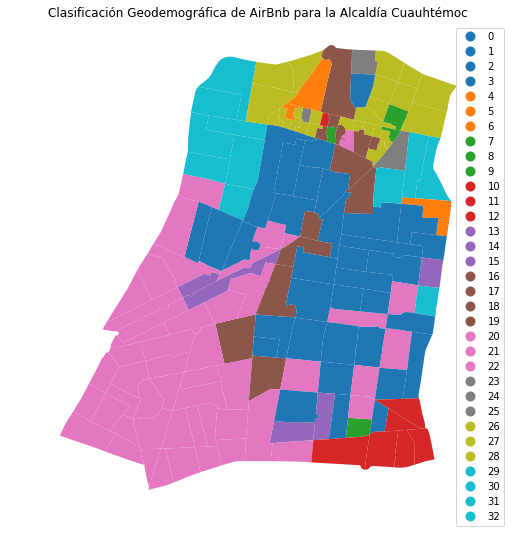

In [23]:
# Crear la figura y sus ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Generar un Mapa de Coropletas Categórico
airbnb.plot(column='azpcls', categorical=True, legend=True, linewidth=0, axes=ax)
# Remover los ejes del mapa
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Asignar un título
plt.title('Clasificación Geodemográfica de AirBnb para la Alcaldía Cuauhtémoc')
# Mostrar el resultado
plt.show()


Inclusive es posible realizar el mismo tipo de análisis estadístico realizado anteriormente, de modo que puedan entenderse con mayor detalle las categorías generadas. Por ejemplo, para conocer el número de observaciones contenidas en cada categoría:

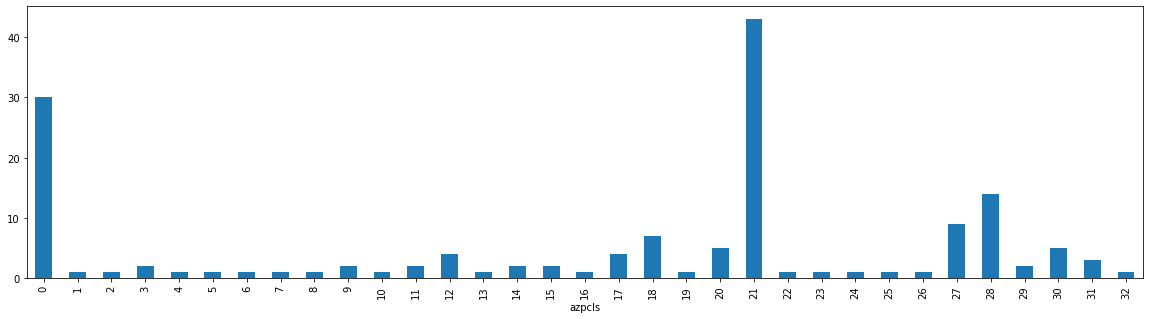

In [24]:
azp_cuentas = airbnb.groupby('azpcls').size()
_ = azp_cuentas.plot.bar(figsize = (20,5))

Asimismo, puede obtenerse un resumen estadístico de lo observado en cada una de las categorías:

In [25]:
azp_promedios = airbnb.groupby('azpcls')[calificaciones].mean()
azp_promedios.T

azpcls,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
calif,94.939440,85.0,86.750,99.500,79.0,82.0,100.0,100.0,100.0,86.45,...,92.0,96.50,83.2,93.0,99.638889,97.910714,86.516650,96.785080,96.400000,100.0
expec,9.734879,7.6,8.500,10.000,7.6,9.4,10.0,10.0,10.0,9.70,...,9.0,10.00,8.2,9.0,9.833333,10.000000,9.416665,9.875554,8.900000,10.0
limp,9.649790,8.0,8.625,9.875,9.4,8.6,10.0,10.0,10.0,9.30,...,10.0,10.00,9.8,9.0,9.888889,9.910714,9.000000,9.850784,9.566667,10.0
checkin,9.850358,9.3,8.625,9.750,8.7,9.1,10.0,10.0,10.0,9.00,...,10.0,10.00,9.8,9.0,10.000000,9.964286,9.583335,9.899602,9.700000,10.0
com,9.817882,7.7,9.000,10.000,9.5,9.5,10.0,10.0,10.0,10.00,...,10.0,10.00,10.0,9.0,9.977778,10.000000,9.150000,9.923226,9.400000,10.0
ubi,9.599153,8.3,7.375,8.625,9.8,10.0,10.0,10.0,8.0,8.90,...,9.0,10.00,7.4,9.0,9.944444,9.517857,9.833335,9.667640,9.050000,10.0
precio,9.647187,7.5,8.375,10.000,8.0,7.6,10.0,10.0,10.0,9.60,...,9.0,9.75,9.4,9.0,9.944444,9.821429,8.783335,9.766524,9.400000,10.0


___
### Mejorando la Visualización - `.dissolve()` en `GeoPandas`
El mapa anterior permite tener una visualización relativamente clara de los límites de las regiones generados por el Algoritmo *AZP*; sin embargo, ésta aún se basa en el coloreado de las áreas (AGEB's) más pequeñas que le componen. Como tal, para obtener propiamente las nuevas regiones, es necesario "fundir" todas las AGEB's que pertenecen a una misma categoría en un sólo polígono.

Lo anterior, dentro de los Sistemas de Información Geográfica, es una operación vectorial conocida como *Disolver* (*Dissolve*); se trata de una operación ampliamente difundida en todos los SIG, y también puede ejecutarse de forma muy sencilla en `GeoPandas` a través de la función [`.dissolve()`](http://geopandas.org/aggregation_with_dissolve.html):

In [26]:
# Almacenar las columnas del 'GeoDataFrame' que son de interés para '.dissolve()'
tmp = airbnb[['azpcls','geometry']]

# Ejecutar la función
colonias_airbnb = tmp.dissolve(by = 'azpcls')

En la celda anterior, se almacena dentro de una variable temporal (`tmp`) las columnas que son de interés para la función `.dissolve()`; en este caso, `azpcls`, debido a que las categorías contenidas en ésta serán las que determinarán qué polígonos se fundirán entre sí, y `geometry`, al contener la geometría de cada polígono. Posteriormente, se ejecuta la función a esta variable, indicando a través del argumento `by` cuál es la columna que regirá la operación.

Para visualizar el resultado, simplemente puede recurrirse a la función `.plot()`, dado que en la celda anterior se generó un nuevo `GeoDataFrame`:

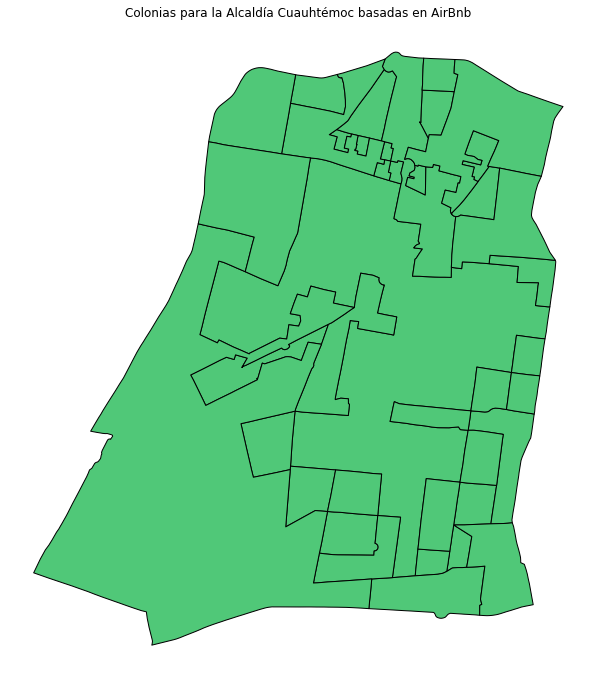

In [27]:
# Crear la figura y sus ejes
fig, ejes = plt.subplots(1, figsize=(12, 12))

# Graficar las nuevas colonias generadas
colonias_airbnb.plot(figsize = (10,10), edgecolor = 'black', facecolor = '#50C878', ax = ejes)

# Remover los ejes del mapa
ejes.set_axis_off()

# Asignar un título
plt.title('Colonias para la Alcaldía Cuauhtémoc basadas en AirBnb')

# Mostrar el resultado
plt.show()

En la celda anterior, el `GeoDataFrame` con las colonias fue almacenado en formato `ShapeFile`; sin embargo, la librería [también ofrece la posibilidad](http://geopandas.org/io.html) de almacenar archivos en formato `GeoJSON` o `GeoPackage`; también es importante tomar en cuenta que el archivo exportado tendrá el mismo Sistema de Coordenadas de Referencia (CRS) que el `GeoDataFrame` original.
___
## Ejercicio Final
Reproduce la práctica, esta vez utilizando el `ShapeFile` dentro de la carpeta de datos bajo el nombre de `agebs_educacion.shp`; éste también contiene todas las AGEB's de la Alcaldía Cuauhtémoc, pero esta vez con datos del Nivel de Escolaridad de los habitantes de cada AGEB. Las variables que contiene son:
* `pob_analf` - Número de habitantes en el AGEB con analfabetismo (No saben leer ni escribir)
* `pob_sinedu` - Habitantes sin escolaridad alguna.
* `pob_basica` - Habitantes que cursaron Primaria y/o Secundaria, pero no la finalizaron
* `pob_secun` - Habitantes que finalizaron, como máximo, hasta el Nivel Básico (Secundaria)
* `pob_bach` - Habitantes que finalizaron, como máximo, hasta el Nivel Medio-Superior (Bachillerato-Preparatoria)
* `pob_sup` - Habitantes que poseen algún grado de Nivel Superior, sea Licenciatura, Maestría o Doctorado.

Para reproducir el ejercicio, es necesario:
* Importar los datos (`agebs_educacion.shp`)
* Crear una Segmentación Demográfica de la población utilizando el Método *K-Means*, así como todas las variables antes mencionadas. Esto implica:
  * Ejecutar el Método *K-Means*.
  * Obtener las etiquetas de clase a las que pertenece cada AGEB.
  * Visualizar las clases en un mapa.
  * Comparar el mapa obtenido con la distribución de las variables a través de, por ejemplo, Mapas de Coropletas.
* Crear una Regionalización con las mismas variables, produciendo nuevamente 33 regiones. Esto implica:
  * Generar la Matriz de Pesos Espaciales para las AGEB's.
  * Ejecutar el Algoritmo de Regionalización *AZP* (o algún otro de tu preferencia)
  * Extrar las etiquetas de región a las que pertenece cada AGEB, y visualizar en un mapa.
  * Comparar el resultado con las Colonias Administrativas de la Alcaldía Cuauhtémoc.
  
  
  ### Solución
 

In [28]:
agebs_edu = gpd.read_file('data/agebs_educacion.shp')  # Importar el ShapeFile
agebs_edu = agebs_edu.set_index('ageb')                # Establecer la Clave Geográfica del AGEB como Índice
print(agebs_edu.head())

variables = agebs_edu.columns[0:6]
variables

               pob_analf  pob_sinedu  pob_basica  pob_secun  pob_bach  \
ageb                                                                    
0901500010625         26          39         255        556       264   
090150001113A         85         159        1358       3714      1737   
090150001152A         47          55         494       1615       680   
0901500010131         30          46         555       1037       535   
090150001049A         18          26         231        655       272   

               pob_sup                                           geometry  
ageb                                                                       
0901500010625      218  POLYGON ((2799047.742 829865.581, 2799053.606 ...  
090150001113A     1551  POLYGON ((2798538.808 827041.130, 2798460.966 ...  
090150001152A      749  POLYGON ((2801011.186 825953.618, 2800937.555 ...  
0901500010131      355  POLYGON ((2800170.368 831443.458, 2800220.149 ...  
090150001049A      334  POLYGON 

Index(['pob_analf', 'pob_sinedu', 'pob_basica', 'pob_secun', 'pob_bach',
       'pob_sup'],
      dtype='object')

Una vez leida la base se selecciona la variable `pob_analf` y se trabaja en la creación de clusters por el metodo de k-mean para luego asignar dichas variables a la base.


In [30]:
kmeans15 = cluster.KMeans(n_clusters=15)

# Ejecutar el algoritmo con las variables establecidas
k15cls = kmeans15.fit(agebs_edu[variables].values)

k15cls.labels_

agebs_edu['k5cls'] = k15cls.labels_


La siguiente representación grafica de los grupos nos puede ayudar a pensar en hipotesis sobre si el espacio afecta con la clasificación. Aunque ya tenemos los metodos usados por clusterpy que contemplan la matriz de pesos espaciales para hacer la clasificación. 

En el caso de este mapa, podemos ver que la educación de una ageb parece depender de la posición, de hecho son pocos los grupos que parece no estar juntos, es decir, tengo la idea de que el rezago espacial es alto.

C:\ProgramData\Anaconda3\envs\curso_geospacial\lib\site-packages\geopandas\plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


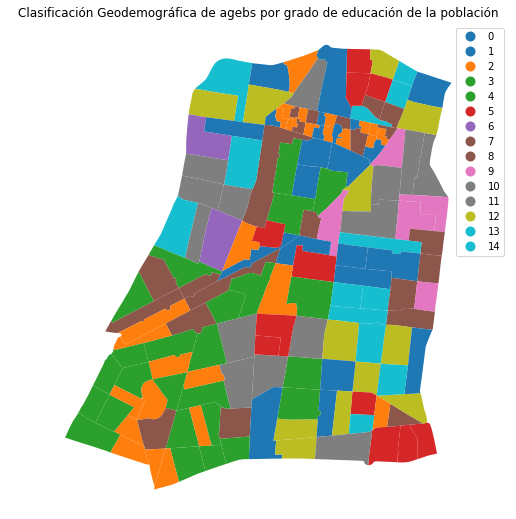

In [31]:
# Crear la figura y sus ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Generar un Mapa de Coropletas Categórico
agebs_edu.plot(column='k5cls', categorical=True, legend=True, linewidth=0, axes=ax)
# Remover los ejes del mapa
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Asignar un título
plt.title('Clasificación Geodemográfica de agebs por grado de educación de la población')
# Mostrar el resultado
plt.show()

Si hicieramos un mapa de coropletas, el cual segmenta las agebs en grupos basados en algun algoritmo de segmentación sobre *una variable*, obtendriamos algo no necesariamente igual al mapa hecho con kmeans.

A continuación usaremos un mapa de coropletas usando los **quantiles como metodo de agrupación** y la variable **pob_analf**, usaremos 15 grupos para tener un comparativo con el mapa de kmeans con n=15.

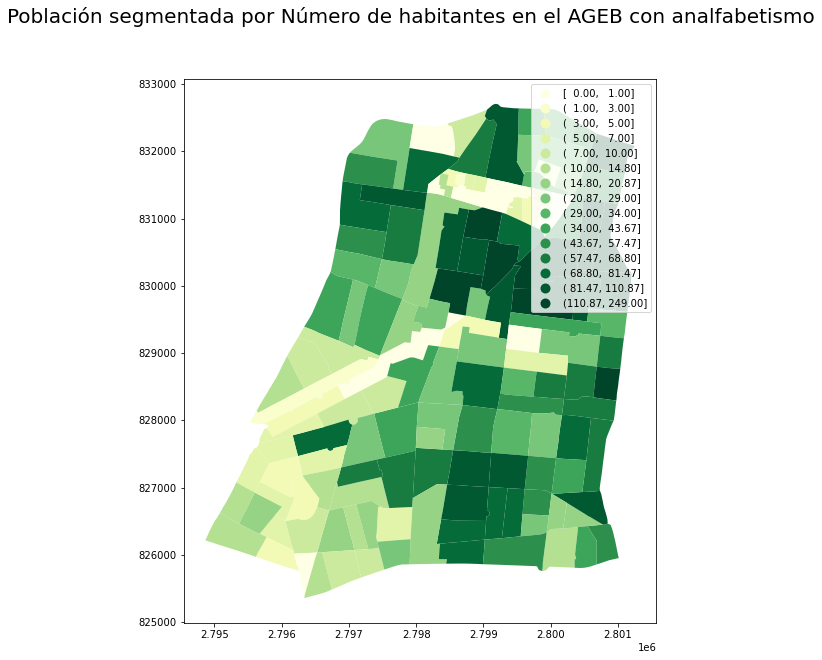

In [38]:
# Preparación de la figura y sus filas
fig , filas = plt.subplots(1, figsize = (10,10))

# Gráfica del GeoDataFrame, generando un Mapa de Coropletas a través de 'scheme'
agebs_edu.plot(ax = filas, column = 'pob_analf', scheme = 'quantiles' , cmap = 'YlGn', legend = True,k=15)

# Adición de título a la gráfica
fig.suptitle('Población segmentada por Número de habitantes en el AGEB con analfabetismo', size = 20)

# Mostrar la gráfica
plt.show()

Podemos ver que este mapa es diferente al construido atraves de kmeans, la justificación es que solo se esta considerando una variable en el mapa de coropletas mientras que en kmeans se considero a todas. Este metodo de quantiles agrupa de manera general intentando ordenar los valores de la variable y creando 15 quantiles, esto es muy diferente en kmeans que los datos no son ordenados si no escogidos aleatoriamente para formar 15 grupos para despues modificar los integrantes de dicho grupo hasta maximizar la desviación estandar entre los grupos pero disminuir la desviación estandar entre los integrantes del grupo, es por ello que el metodo se dice centra los datos a una media.

Para realizar la regionalización de las agebs usaremos la paqueteria **clusterpy**, para ello leeremos los datos y definiremos una matriz de pesos reina, porque como ya se comento en otras noteebooks, *la Contigüidad se define como las relaciones espaciales a través de la existencia de fronteras comúnes*, y creemos que hay relacion entre la posición espacial de una población y la educación de esa población.

Usaremos el criterio Torre por ser un poco más robusto con las fronteras en cuanto a que no solo basta que compartan un vertice si no todo un segmento, haciendo más cerrado el grupo de vecinos

In [40]:
layer = clusterpy.importArcData('data/agebs_educacion')
layer.cluster('azp', variables, 33, wType='rook')

Loading data/agebs_educacion.dbf
Loading data/agebs_educacion.shp
Done
Getting variables
Variables successfully extracted
Running original AZP algorithm (Openshaw and Rao, 1995)
Number of areas:  153
Number of regions:  33
Constructing regions
initial Solution:  [25, 8, 17, 32, 25, 25, 8, 3, 20, 17, 3, 32, 5, 3, 17, 11, 25, 23, 3, 24, 3, 32, 2, 32, 32, 19, 19, 19, 19, 19, 32, 32, 32, 32, 2, 19, 19, 25, 25, 25, 32, 25, 25, 25, 25, 25, 25, 25, 32, 32, 32, 7, 21, 25, 25, 25, 25, 25, 25, 25, 27, 32, 32, 19, 19, 18, 16, 16, 16, 28, 28, 14, 16, 16, 26, 29, 29, 16, 28, 10, 30, 4, 13, 29, 0, 25, 25, 25, 4, 28, 1, 1, 4, 29, 1, 5, 25, 3, 25, 31, 15, 15, 15, 15, 25, 9, 9, 3, 15, 15, 9, 3, 12, 23, 15, 15, 23, 3, 3, 3, 8, 8, 23, 23, 6, 3, 20, 3, 3, 8, 11, 23, 11, 17, 3, 22, 20, 3, 3, 3, 17, 3, 20, 3, 20, 20, 3, 3, 11, 11, 17, 25, 25]
initial O.F:  61779533.0
Performing local search
FINAL SOLUTION:  [25, 8, 17, 32, 25, 25, 8, 3, 20, 17, 3, 32, 5, 3, 17, 11, 25, 23, 3, 24, 3, 32, 2, 19, 19, 19, 19, 1

In [41]:
agebs_edu['azpcls'] = layer.region2areas
agebs_edu.head()

,pob_analf,pob_sinedu,pob_basica,pob_secun,pob_bach,pob_sup,geometry,k5cls,azpcls
ageb,,,,,,,,,
0901500010625,26,39,255,556,264,218,"POLYGON ((2799047.742 829865.581, 2799053.606 ...",8,25
090150001113A,85,159,1358,3714,1737,1551,"POLYGON ((2798538.808 827041.130, 2798460.966 ...",4,8
090150001152A,47,55,494,1615,680,749,"POLYGON ((2801011.186 825953.618, 2800937.555 ...",5,17
0901500010131,30,46,555,1037,535,355,"POLYGON ((2800170.368 831443.458, 2800220.149 ...",13,32
090150001049A,18,26,231,655,272,334,"POLYGON ((2798161.490 831384.472, 2798257.964 ...",8,25


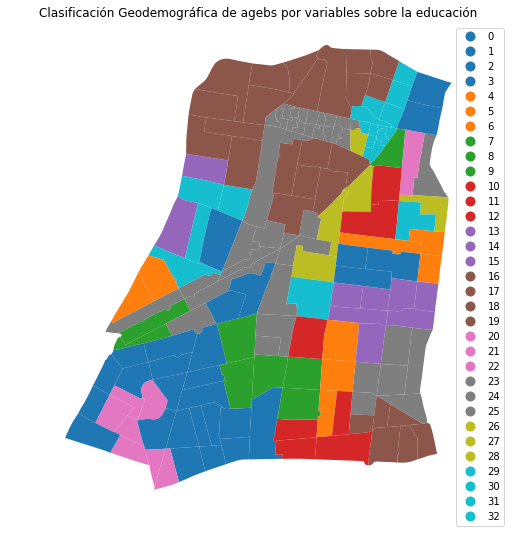

In [43]:
# Crear la figura y sus ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Generar un Mapa de Coropletas Categórico
agebs_edu.plot(column='azpcls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remover los ejes del mapa
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Asignar un título
plt.title('Clasificación Geodemográfica de agebs por variables sobre la educación')
# Mostrar el resultado
plt.show()

Tomando la matriz de pesos espaciales Torre obtenemos un agrupamiento diferente al obtenido por kmeans, que no contempla dicha matriz.
Aunque la nueva clasificación comparte ciertas similitudes con las de kmeans (estrictamente me refiero a que algunas agebs siguen perteneciendo al mismo grupos, pero al ser un numero mayor de grupos entonces es normal que exista diferencias), no se debe esperar que kmeans sea adecuado para el analisis de estos datos ya que no considera la información extra proporcionada por el mapa y que el metodo  Automated Zoning Procedure (AZP) si contempla.